## Get ENCODE metadata of all experiments, files, biosamples
Load/download ENCODE reports and metadata. We can go with report.tsv or /metadata/. 

However, report.tsv returns a lot more entries. Did not look into the differences (should be the same after filtering).

Query again to obtain extra fields for each file (dbxrefs and biosample)

Merge report_file, report_file_extra, and report_sam (report_expt is not used for now)

### ToDo
1. Consider to remove some unused columns in the output

In [ ]:
import io
import requests
import importlib
import pandas as pd
from pathlib import Path
from collections import Counter
import brew_omics

# limit=all gives you the default "report" columns.
# One can get similar output by visiting the URL below in a web browser (adding &format=text to get TSV):
#  https://www.encodeproject.org/search/?type=Experiment&status=released

report_file, report_file_path = brew_omics.fetch_encode_metadata(
    "data/encode/report_file.pkl",
    "https://www.encodeproject.org/report.tsv?type=File&limit=all", 
    check_ids=['ID', 'Dataset'], 
    data_type='File')

report_sam, report_sam_path = brew_omics.fetch_encode_metadata(
    "data/encode/report_sam.pkl",
    "https://www.encodeproject.org/report.tsv?type=Biosample&limit=all", 
    check_ids=['ID'], 
    data_type='Biosample')

report_expt, report_expt_path = brew_omics.fetch_encode_metadata(
    "data/encode/report_expt.pkl",
    "https://www.encodeproject.org/report.tsv?type=Experiment&limit=all", 
    check_ids=['ID'], 
    data_type='Experiment')

# The return only has two columns: ID and Aliases (not useful)
report_replicate, report_replicate_path = brew_omics.fetch_encode_metadata(
    "data/encode/report_replicate.pkl",
    "https://www.encodeproject.org/report.tsv?type=Replicate&limit=all", 
    check_ids=['ID', 'Dataset'], skip_rows=1,
    data_type='Replicate', overwrite=True)

# metadata query appears to always return one row per file, even though type=Experiment or type=Biosample is specified
# metadata_file, metadata_file_path = fetch_encode_metadata(
#     "data/encode/metadata_file.pkl",
#     "https://www.encodeproject.org/metadata/?type=File&limit=all", 
#     # url = "https://www.encodeproject.org/metadata/?type=Experiment&field=replicate.library.biosample.accession&field=replicate.library.biosample.dbxrefs"    
#     # url = "https://www.encodeproject.org/metadata/?type=Experiment&limit=all"
#     check_ids=['ID', 'Dataset'],
#     data_type='File')

Loaded cached ENCODE File metadata with shape: (1560619, 47)
File metadata column 'ID' value counts: Counter({'files': 1560619})
File metadata column 'Dataset' value counts: Counter({'experiments': 860267, 'annotations': 672401, 'functional-characterization-experiments': 10533, 'single-cell-units': 8288, 'references': 5942, 'reference-epigenomes': 2157, 'aggregate-series': 688, 'functional-characterization-series': 211, 'ucsc-browser-composites': 100, 'replication-timing-series': 14, 'matched-sets': 10, 'projects': 4, 'multiomics-series': 3, 'treatment-time-series': 1})
Loaded cached ENCODE Biosample metadata with shape: (29930, 29)
Biosample metadata column 'ID' value counts: Counter({'biosamples': 29930})
Loaded cached ENCODE Experiment metadata with shape: (27396, 40)
Experiment metadata column 'ID' value counts: Counter({'experiments': 27396})


In [42]:
# Search Encode again to get dbxrefs and biosample id and for each file
file_extra_path = Path("data/encode/report_file_extra.pkl")
fields_list = [
    "accession",
    # "file_format",
    # "file_type",
    "dbxrefs",
    # "replicate.library.accession",
    "replicate.library.biosample",
    "replicate.library.dbxrefs",
    "donors",
    # "output_type",
    # "derived_from",
    "cloud_metadata.url",
    "cloud_metadata.md5sum_base64",
    "cloud_metadata.file_size",
    "s3_uri",
    "azure_uri",
    # "status",
]
if file_extra_path.exists():
    report_file_extra = pd.read_pickle(file_extra_path)
    print(f"Loaded cached ENCODE file extra fields with shape: {report_file_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=File&field=" + '&field='.join(fields_list)
    report_file_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=file_extra_path)

report_file_extra.rename(columns={
    'External resources': 'dbxrefs',
    'replicate.library.accession': 'Biosample library',
    'replicate.library.biosample': 'Biosample accession',
    }, inplace=True)
report_file_extra['Biosample accession'] = report_file_extra['Biosample accession'].str.strip('/')
report_file_extra['Biosample accession'] = report_file_extra['Biosample accession'].str.replace('biosamples/', '')
if 'Status' in report_file_extra.columns:
    report_file_extra.drop(columns=['Status'], inplace=True)

# Search Encode again to get extra fields for each biosample
sam_extra_path = Path("data/encode/report_sam_extra.pkl")
fields_list = [
    "accession",
    "dbxrefs",
    "donor",
    "sex",
    # "life_stage",
    'origin_batch',
    # 'parent_of',
    'perturbed',
    # 'status',
]
if sam_extra_path.exists():
    report_sam_extra = pd.read_pickle(sam_extra_path)
    print(f"Loaded cached ENCODE sample extra fields with shape: {report_sam_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=Biosample&field=" + '&field='.join(fields_list)
    report_sam_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=sam_extra_path)


# Search Encode again to get extra fields for each experiment
expt_extra_path = Path("data/encode/report_expt_extra.pkl")
fields_list = [
    "accession",
    # "dbxrefs",
    "replicates.accession", # the three fields below all returned empty
    "replicates.biosample.accession",
    "replicates.donor.accession",
    "replicates.biological_replicate_number",
    "replicates.technical_replicate_number",
    "replicates.@id",
    "replicates.origin_batch",
    "files.dbxrefs",
    "files.accession",
    # "files.read_count",
    # "files.read_length",
    # "files.run_type",
    # "status",
]
if expt_extra_path.exists():
    report_expt_extra = pd.read_pickle(expt_extra_path)
    print(f"Loaded cached ENCODE experiment extra fields with shape: {report_expt_extra.shape}")
else:
    url = "https://www.encodeproject.org/report.tsv?type=Experiment&field=" + '&field='.join(fields_list)
    report_expt_extra = brew_omics.query_encode_to_dataframe(url, skip_rows=1, sep='\t', save_path=expt_extra_path)
    

Loaded cached ENCODE file extra fields with shape: (1560649, 10)
Loaded cached ENCODE sample extra fields with shape: (29934, 6)
Loaded cached ENCODE experiment extra fields with shape: (27398, 10)


In [ ]:
### Set index and remove duplicates

def check_merge_data_extra(data_df: pd.DataFrame, extra_df: pd.DataFrame,
                           key='Accession', data_type='File', save_path=None) -> pd.DataFrame:
    """
    Given a main data DataFrame and an extra data DataFrame, set index to 'key' and remove duplicates.
    """

    # set index to 'Accession' while keeping the column for easier merging later
    data_df.set_index(key, inplace=True, drop=False)
    data_df.index.name = 'Index'

    duplicates_data = data_df[data_df.duplicated(subset=[key], keep=False)]
    print(f"Found {len(duplicates_data)} duplicate accessions in {key} data of type {data_type}.")
    if len(duplicates_data) > 0:
        data_df = data_df.drop_duplicates(subset=[key], keep='first').reset_index(drop=True)
    
    duplicate_extra = extra_df[extra_df.duplicated(subset=[key], keep=False)]
    print(f"Found {len(duplicate_extra)} duplicate accessions in {key} extra data of type {data_type}.")
    if len(duplicate_extra) > 0:
        extra_df = extra_df.drop_duplicates(subset=[key], keep='first').reset_index(drop=True)

    merged_df = data_df.merge(extra_df, on=key, suffixes=('', '_extra'), how='left')
    print(f"Merged {data_type} data shape: {merged_df.shape}")

    if save_path is not None:
        merged_df.to_pickle(Path(save_path).with_suffix('.pkl'))
        merged_df.to_csv(Path(save_path).with_suffix('.csv'), index=False)
        merged_df.to_csv(Path(save_path).with_suffix('.tsv'), index=False, sep='\t')
        print(f"Saved merged {data_type} data to {save_path}")

    return merged_df

report_file_merged = check_merge_data_extra(
    report_file, report_file_extra, key='Accession',
    data_type='File', save_path="data/encode/report_file_merged.pkl")

report_sam_merged = check_merge_data_extra(
    report_sam, report_sam_extra, key='Accession',
    data_type='Biosample', save_path="data/encode/report_sam_merged.pkl")
    
report_expt_merged = check_merge_data_extra(
    report_expt, report_expt_extra, key='Accession',
    data_type='Experiment', save_path="data/encode/report_expt_merged.pkl")

print(f"Merging report_file_all shape: {report_file_merged.shape}, report_sam shape: {report_sam_merged.shape}")
# sam_columns = ['ID', 'Biosample age', 'Biosample term name', 'Biosample classification', 'Biosample treatment', 'Organism', 'Child biosamples']
report_file_biosample = pd.merge(report_file_merged, report_sam_merged, left_on='Biosample accession', right_on='Accession', how='left', suffixes=('', '_sam'))
report_file_biosample.drop(columns=['ID_sam', 'Accession_sam'], inplace=True)
print(f"Final merged file report shape: {report_file_biosample.shape}")
report_file_biosample.to_pickle("data/encode/report_file_biosample.pkl")
report_file_biosample.to_csv("data/encode/report_file_biosample.csv", index=False)
print("Saved final merged file report to data/encode/report_file_biosample.pkl/csv")

Found 1283 duplicate accessions in Accession data of type File.
Found 1283 duplicate accessions in Accession extra data of type File.
Merged File data shape: (1559337, 56)
Saved merged File data to data/encode/report_file_merged.pkl
Found 0 duplicate accessions in Accession data of type Biosample.
Found 0 duplicate accessions in Accession extra data of type Biosample.
Merged Biosample data shape: (29930, 34)
Saved merged Biosample data to data/encode/report_sam_merged.pkl
Found 0 duplicate accessions in Accession data of type Experiment.
Found 0 duplicate accessions in Accession extra data of type Experiment.
Merged Experiment data shape: (27396, 49)
Saved merged Experiment data to data/encode/report_expt_merged.pkl


## Query ENCODE one by one for comprehensive info (under construction)
1. Filter the lumpsum files to get RNA-seq experiments and files
2. Download more detailed metadata for experiment, file, or sample (just for examples only)

3. Query each experiment to obtain detailed information on samples, files etc.

### Note on individual experiment queries
A lot of info is returned from individual expt queries, such as information for all files,  sample replicates and SRA:SRR information. 
1. For each file, returns origin_batches (for sample info), tech/bio-replicate numbers, and SRA:SRR if applicable. These should enable us to get the specific Biosample accession. fastq files come with more detailed information, but it still only provides replicate info and origin_batches, not specific biosample.

2. For each replicate, it gives details including Biosample accession, origin_batch, library, donor, etc.
3. I didn't go through this route as I "presumed" that it will be too slow to query each expt. The current method is to search all Files at once and ask for Biosample accession, which appears to be only available for very upstream files such as fastq. (Need a closer look here)

### Note on getting SRR ids
Gemini claims that one can download the metadata containing SRR ids for all experiments at once. I tried a few times, with no success. You may have better luck. Try this:
1) Paste this line in browser: https://www.encodeproject.org/metadata/?control_type%21=%2A&status=released&perturbed=false&assay_title=scRNA-seq&assay_title=polyA+plus+RNA-seq&assay_title=total+RNA-seq&assay_title=polyA+minus+RNA-seq&assay_title=snRNA-seq&assay_title=long+read+RNA-seq&assay_title=long+read+scRNA-seq&assay_title=small+RNA-seq&assay_title=microRNA-seq&type=Experiment&files.analyses.status=released&files.preferred_default=true
2) It should download the metadata csv (but I wasn't able to get it)

In [ ]:
import pandas as pd
if 'report_expt' not in globals():
    report_expt = pd.read_pickle(report_expt_path)

expt_rnaseq = report_expt[report_expt['Assay name'].str.contains('RNA-seq', case=False, na=False)].copy()
print(f"Found {len(expt_rnaseq)} RNA-seq experiments out of {len(report_expt)} ({len(expt_rnaseq)/len(report_expt)*100:.1f}%).")
# 'Biosample accession' column contains the ENCBS IDs that are comma-separated.
# expt_rnaseq['Biosample accession'] = expt_rnaseq['Biosample accession'].str.split(',')


if 'report_file' not in globals():
    report_file = pd.read_pickle(report_file_path)
file_rnaseq = report_file[report_file['Assay term name'].str.contains('RNA-seq', case=False, na=False)].copy()
print(f"Found {len(file_rnaseq)} RNA-seq files out of {len(report_file)} ({len(file_rnaseq)/len(report_file)*100:.1f}%).")
# further filter to only fastq files
rnaseq_fastq = file_rnaseq[file_rnaseq['File Format'] == 'fastq'].copy()
print(f"Found {len(rnaseq_fastq)} RNA-seq fastq files out of {len(file_rnaseq)} ({len(rnaseq_fastq)/len(file_rnaseq)*100:.1f}%).")

rnaseq_bam = file_rnaseq[file_rnaseq['File Format'] == 'bam'].copy()
print(f"Found {len(rnaseq_bam)} RNA-seq bam files out of {len(file_rnaseq)} ({len(rnaseq_bam)/len(file_rnaseq)*100:.1f}%).")

# 3. Get the unique Biosample IDs (ENCBS...)
# This is the "key" to finding other experiments for the same samples

# rnaseq_biosamples_df = expt_rnaseq.explode('Biosample accession')
# biosamples_list = rnaseq_biosamples_df['Biosample accession'].unique().tolist()

# print(f"Found {len(expt_rnaseq)} RNA-seq experiments across {len(biosamples_list)} unique biosamples.")

In [ ]:
# check the number of empty "Batch" column values in rnaseq_fastq and rnaseq_bam 
empty_batch_fastq = rnaseq_fastq['Batch'].isna().sum()
empty_batch_bam = rnaseq_bam['Batch'].isna().sum()
print(f"RNA-seq fastq files with empty 'Batch': {empty_batch_fastq} out of {len(rnaseq_fastq)}")
print(f"RNA-seq bam files with empty 'Batch': {empty_batch_bam} out of {len(rnaseq_bam)}")

# check how many "Batch" values have "," in them (multiple batches)
multi_batch_fastq = rnaseq_fastq['Batch'].str.contains(',', na=False).sum()
multi_batch_bam = rnaseq_bam['Batch'].str.contains(',', na=False).sum()
print(f"RNA-seq fastq files with multiple 'Batch' values: {multi_batch_fastq} out of {len(rnaseq_fastq)}")
print(f"RNA-seq bam files with multiple 'Batch' values: {multi_batch_bam} out of {len(rnaseq_bam)}") 

In [ ]:
import requests
from pathlib import Path

def encode_fetch_json(url, save_path=None):
    """Fetches JSON data from an ENCODE URL."""
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)        
        with open(save_path, 'w') as f:
            f.write(response.text)
    return response.json()

def get_file_metadata(file_accession):
    """Fetches SRR (Run) IDs for an ENCODE file."""
    url = f"https://www.encodeproject.org/files/{file_accession}/?format=json"
    save_path = f'data/encode/files/{file_accession}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    srr_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRR')]
    return srr_ids
    
def get_sample_metadata(biosample_id):
    """Fetches SRP (Study) and SRR (Run) IDs for an ENCODE biosample."""
    url = f"https://www.encodeproject.org/biosamples/{biosample_id}/?format=json"
    save_path = f'data/encode/biosamples/{biosample_id}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    # 1. Get SRP (Study ID) - usually at the experiment level
    srp_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRP')]
    gse_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('GEO:GSE')]
    
    # 2. Get SRR (Run IDs) - usually found in the files
    srr_ids = []
    accession_ids = []
    read_counts = []
    read_lengths = []
    run_types = []
    paired_ends = []
    tech_replicate_numbers = []
    bio_replicate_numbers = []

    for file in data.get('files', []):
        for ref in file.get('dbxrefs', []):
            if ref.startswith('SRA:SRR'):
                srr_ids.append(ref.split(':')[1])
                accession_ids.append(file.get('accession'))
                read_counts.append(file.get('read_count', 0))
                read_lengths.append(file.get('read_length', 0))
                run_types.append(file.get('run_type', ''))
                paired_ends.append(file.get('paired_end', ''))
                tech_replicate_numbers.append(file.get('replicate', {}).get('technical_replicate_number', ''))                
                bio_replicate_numbers.append(file.get('replicate', {}).get('biological_replicate_number', ''))
                
    return {
        "Biosample": biosample_id,
        "SRP": srp_ids[0] if srp_ids else None,
        "SRRs": srr_ids, # list(set(srr_ids)),
        "accession IDs": accession_ids,
        "Read Counts": read_counts,
        "Read Lengths": read_lengths,
        "Run Types": run_types,
        "Paired Ends": paired_ends,
        "Tech Replicate Numbers": tech_replicate_numbers,
        "Bio Replicate Numbers": bio_replicate_numbers,
        "GSE": gse_ids[0] if gse_ids else None,
    }

def get_expt_metadata(experiment_id):
    """Fetches SRP (Study) and SRR (Run) IDs for an ENCODE experiment."""
    url = f"https://www.encodeproject.org/experiments/{experiment_id}/?format=json"
    save_path = f'data/encode/experiments/{experiment_id}.json'
    data = encode_fetch_json(url, save_path=save_path)
    
    # 1. Get SRP (Study ID) - usually at the experiment level
    srp_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('SRA:SRP')]
    gse_ids = [ref.split(':')[1] for ref in data.get('dbxrefs', []) if ref.startswith('GEO:GSE')]
    
    # 2. Get SRR (Run IDs) - usually found in the files
    srr_ids = []
    accession_ids = []
    read_counts = []
    read_lengths = []
    run_types = []
    paired_ends = []
    tech_replicate_numbers = []
    bio_replicate_numbers = []

    for file in data.get('files', []):
        for ref in file.get('dbxrefs', []):
            if ref.startswith('SRA:SRR'):
                srr_ids.append(ref.split(':')[1])
                accession_ids.append(file.get('accession'))
                read_counts.append(file.get('read_count', 0))
                read_lengths.append(file.get('read_length', 0))
                run_types.append(file.get('run_type', ''))
                paired_ends.append(file.get('paired_end', ''))
                tech_replicate_numbers.append(file.get('replicate', {}).get('technical_replicate_number', ''))                
                bio_replicate_numbers.append(file.get('replicate', {}).get('biological_replicate_number', ''))
                
    # 3. Get Biosample IDs
    biosample_ids = data.get('biosample_term_name', [])

    return {
        "Experiment": experiment_id,
        "SRP": srp_ids[0] if srp_ids else None,
        "SRRs": srr_ids, # list(set(srr_ids)),
        "accession IDs": accession_ids,
        "Read Counts": read_counts,
        "Biosample Terms": biosample_ids,
        "Read Lengths": read_lengths,
        "Run Types": run_types,
        "Paired Ends": paired_ends,
        "Tech Replicate Numbers": tech_replicate_numbers,
        "Bio Replicate Numbers": bio_replicate_numbers,
        "GSE": gse_ids[0] if gse_ids else None,
    }

expt_metadata_list = []
for expt_id in expt_rnaseq['Accession'].head(5):
    metadata = get_expt_metadata(expt_id)
    expt_metadata_list.append(metadata)
expt_metadata_df = pd.DataFrame(expt_metadata_list)
print(f"Compiled metadata for {len(expt_metadata_df)} experiments.")

file_metadata_list = []
for file_id in rnaseq_bam['Accession'].head(5):
    metadata = get_file_metadata(file_id)
    file_metadata_list.append(metadata)
file_metadata_df = pd.DataFrame(file_metadata_list)
print(f"Compiled metadata for {len(file_metadata_df)} files.")

file_metadata_list = []
for file_id in rnaseq_fastq['Accession'].head(5):
    metadata = get_file_metadata(file_id)
    file_metadata_list.append(metadata)
file_metadata_df = pd.DataFrame(file_metadata_list)
print(f"Compiled metadata for {len(file_metadata_df)} files.")

sam_meta_list = []
for biosample_acc in expt_rnaseq['Biosample accession'].head(5):
    for biosample_acc in biosample_acc.split(','):
        metadata = get_sample_metadata(biosample_acc) 
        sam_meta_list.append(metadata)
sam_metadata_df = pd.DataFrame(sam_meta_list)
print(f"Compiled metadata for {len(sam_metadata_df)} biosamples.")

## Filter files based on biosample, organism, classification, etc.
If this approach misses some critical info, we may need to query each expt

### ToDo
1. These columns may be useful: "Batch", "Derived_from", "Parent of"

In [ ]:
if 'report_file_biosample' not in globals():
    report_file_biosample = pd.read_pickle("data/encode/report_file_biosample.pkl")
    print(f"Loaded ENCODE file biosample data with shape: {report_file_biosample.shape}")
report_file_biosample.set_index('Accession', inplace=True, drop=False)
report_file_biosample.index.name = 'Index'
    
files_with_biosample = report_file_biosample[report_file_biosample['Biosample accession'].notna()]
print(f"Files with Biosample accession: {len(files_with_biosample)}")
files_with_biosample.to_pickle("data/encode/files_with_biosample.pkl")
files_with_biosample.to_csv("data/encode/files_with_biosample.csv", index=False)

# Check if two columns "Batch" and "Biosample accession" are the same in encode_file_biosample
# "Batch" is from "origin_batch" in sam.json. It may refer to the sample itself or its parent sample in a batch
# Not sure what Batch exactly means in ENCODE context: the samples are not actually derived from the same biosample
batch_biosample_comparison = files_with_biosample[['Batch', 'Biosample accession']].copy()
batch_biosample_comparison['Batch_equals_Biosample'] = batch_biosample_comparison['Batch'] == batch_biosample_comparison['Biosample accession']
batch_equals_count = batch_biosample_comparison['Batch_equals_Biosample'].sum()
print(f"Number of rows where 'Batch' equals 'Biosample accession': {batch_equals_count} out of {len(batch_biosample_comparison)}")

Files with missing Biosample accession: 1366436 out of 1559337
Files with Biosample accession: 192901
Number of rows where 'Batch' equals 'Biosample accession': 0 out of 192901


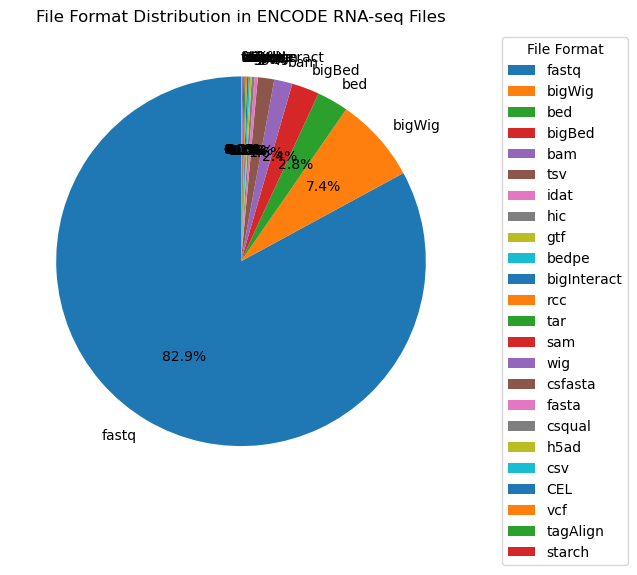

In [46]:
# Do a pie plot of the 'File format' column of file_biosample_filtered
from matplotlib import pyplot as plt
file_format_counts = files_with_biosample['File Format'].value_counts()
plt.figure(figsize=(8, 6))
file_format_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('File Format Distribution in ENCODE RNA-seq Files')
plt.ylabel('')
plt.legend(title='File Format', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [64]:
organism = 'Homo sapiens'
file_biosample_filtered = files_with_biosample[files_with_biosample['Organism'] == organism]
print(f"Files with Organism '{organism}': {len(file_biosample_filtered)} out of {len(files_with_biosample)}")

sam_type = 'tissue'
file_biosample_filtered2 = file_biosample_filtered[file_biosample_filtered['Biosample classification'].str.contains(sam_type, case=False, na=False)]
print(f"Files with Biosample classification containing '{sam_type}': {len(file_biosample_filtered2)}")

# find biosamples whose group has rows with "Assay term name" containing "RNA-seq" and rows with "Assay term name" containing "DNase-seq"
assay_types = ['RNA-seq', 'DNase-seq']
final_biosample_list = []
final_file_biosample = []

files_groupby_biosample = file_biosample_filtered2.groupby('Biosample accession')
print(f"Found {len(files_groupby_biosample)} unique biosamples with organism '{organism}' and classification '{sam_type}'.")

for biosample_acc, biosample_group in files_groupby_biosample:
    has_assay_terms = [any(biosample_group['Assay term name'].str.contains(assay_type, case=False, na=False)) for assay_type in assay_types]
    if all(has_assay_terms):
        final_biosample_list.append(biosample_acc)
        final_file_biosample.append(biosample_group)
print(f"Found {len(final_biosample_list)} biosamples with both {', '.join(assay_types)} assay types.")
final_file_biosample = pd.concat(final_file_biosample)

final_file_biosample.to_pickle("data/encode/final_file_biosample.pkl")
final_file_biosample.to_csv("data/encode/final_file_biosample.csv", index=False)
print("Saved final filtered file biosample data to data/encode/final_file_biosample.pkl/csv")

Files with Organism 'Homo sapiens': 157436 out of 192901
Files with Biosample classification containing 'tissue': 25941
Found 3281 unique biosamples with organism 'Homo sapiens' and classification 'tissue'.
Found 126 biosamples with both RNA-seq, DNase-seq assay types.
Saved final filtered file biosample data to data/encode/final_file_biosample.pkl/csv


## Download files for each sample

I have looked into various ways to find all files associated with a specific sample, which turns out to be not so straightforward. One main reason is that the replicate.library.biosample field is only provided for some file types (e.g., fastq), unfortunately not for downstream files (e.g., bam) we want to directly use without having to process raw data. I have tried/thought of the following:

1. Get the replicate id of a file in the form of /replicates/NNNN... This however is only available for raw data files. 
2. Get the Library accession(s) associated with each sample (possibly with multiple libraries). But only "raw data" (?) files have library accession (only checked one bam file without library info). Biosample also doesn't have libary info either. 
3. Get the biological replicate number, technical replicate number, and donor info provided for each file, and then use it to track the biosample id. This might still work if first getting the experiment for the file and then find out which sample has the biological replicate and technical replicate number in that experiment. This should be doable as the experiment report gives replicate(s) and biosample(s) information. One issue is that different replicates may have the same Biosample id and the experiment report appears to merge the same IDs, making matching replicate_no-sample_id ambiguous (need to check this further, looks promising. Note that different technical replicates usually have the same Biosample id)

I tried to download the biosample accessions together with replicate numbers (both bio and tech) when querying report.tsv?type=Experiment. However, biosample and replicate accessions returned empty. Experiment report does provide a list of replicate ids. So one way to get the replicates-biosample matchup is to search replicates (e.g., report.tsv?type=Replicate)

4. This is the method implemented by looking at the "Derived form" field of downstream files and HOPING the upstream file(s) has biosmaple id.

### Note on downloading processed files
We may want to also check the file analysis method/pipeline used to be consistent

In [ ]:
# For each biosample_id, get its ENCODE page and save the page into a png image
for biosample_acc in files_groupby_biosample.groups.keys():
    url = f"https://www.encodeproject.org/{biosample_acc.strip('/')}/"
    save_path = f"data/encode/{biosample_acc.strip('/')}.png"
    print(f"Saving ENCODE page {url} to {save_path} with ")
    !wkhtmltoimage --width 1024 --height 0 {url} {save_path}
    break  # just do one for testing

Saving ENCODE page https://www.encodeproject.org/biosamples/ENCBS001KXB/ to data/encode/biosamples/ENCBS001KXB.png with 
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [65]:
# Each biosample as a group and download files for each assay type
assay_file_types = {
    'RNA-seq': ['bam',],
    'DNase-seq': ['bam',],
}

report_file_biosample.set_index('Accession', inplace=True, drop=False)
report_file_biosample.index.name = 'Index'

files_groupby_biosample = report_file_biosample.groupby('Biosample accession')
files_groupby_dataset = report_file_biosample.groupby('Dataset')

dataset_path = Path(f"data/encode/dataset")

importlib.reload(brew_omics)
saved_file_accessions = brew_omics.download_encode_files_groupby_biosample(
    report_file_biosample, # The master metata is needed to find other files (e.g., bam, bigwig) from the same samples
    biosample_accessions=final_biosample_list,
    assay_file_types=assay_file_types,
    dataset_path=dataset_path,
    files_groupby_biosample=files_groupby_biosample,
    files_groupby_dataset=files_groupby_dataset,
    download_now=False,
)

print(f"Downloaded a total of {len(saved_file_accessions)} files for selected biosamples and assay types.")
final_files_downloaded = report_file_biosample[report_file_biosample['Accession'].isin(saved_file_accessions)]
final_files_downloaded.to_pickle("data/encode/final_files_downloaded.pkl")
final_files_downloaded.to_csv("data/encode/final_files_downloaded.csv", index=False)
print("Saved final downloaded files metadata to data/encode/final_files_downloaded.pkl/csv")

Biosamples:   0%|          | 0/126 [00:00<?, ?it/s]

Biosample: ENCBS008QPC; saved metadata to data/encode/dataset/ENCBS008QPC.csv
    Assay: RNA-seq, Datasets: ['/experiments/ENCSR817TLH/']


Biosamples:   8%|▊         | 10/126 [00:03<00:27,  4.24it/s]

    Dataset /experiments/ENCSR817TLH/ has 50 files.
        Excluding 3 'transcriptome alignments' bam files for RNA-seq assay.
    File accession: ENCFF709WUU
        Checking derived from accession: /files/ENCFF511CCS/ for file accession: ENCFF709WUU
        File accession: ENCFF511CCS is directly from biosample: ENCBS008QPC
        File data/encode/dataset/ENCBS008QPC/RNA-seq/ENCFF709WUU.bam already exists, skipping download.
    File accession: ENCFF515EAJ
        Checking derived from accession: /files/ENCFF793NBF/ for file accession: ENCFF515EAJ
        File accession: ENCFF793NBF is directly from biosample: ENCBS008QPC
    File accession: ENCFF344BDW
        Checking derived from accession: /files/ENCFF793NBF/ for file accession: ENCFF344BDW
        File accession: ENCFF793NBF is directly from biosample: ENCBS008QPC
    Assay: DNase-seq, Datasets: ['/experiments/ENCSR426TPQ/']
    Dataset /experiments/ENCSR426TPQ/ has 60 files.
    File accession: ENCFF235FOP
        Checking de

Biosamples:  22%|██▏       | 28/126 [00:03<00:06, 15.51it/s]

    File accession: ENCFF826UOG
        Checking derived from accession: /files/ENCFF527HRM/ for file accession: ENCFF826UOG
        File accession: ENCFF527HRM is directly from biosample: ENCBS122USS
    File accession: ENCFF261TPF
        Checking derived from accession: /files/ENCFF598IDH/ for file accession: ENCFF261TPF
        Checking derived from accession: /files/gencode.v29.primary_assembly.annotation_UCSC_names/ for file accession: ENCFF598IDH
        File accession: gencode.v29.primary_assembly.annotation_UCSC_names not found in report_file_biosample index.
        Checking derived from accession: /files/gencode.v29.tRNAs/ for file accession: ENCFF598IDH
        File accession: gencode.v29.tRNAs not found in report_file_biosample index.
        Checking derived from accession: /files/GRCh38_no_alt_analysis_set_GCA_000001405.15/ for file accession: ENCFF598IDH
        File accession: GRCh38_no_alt_analysis_set_GCA_000001405.15 not found in report_file_biosample index.
       

Biosamples:  37%|███▋      | 47/126 [00:03<00:02, 31.61it/s]

Biosample: ENCBS246MHN; saved metadata to data/encode/dataset/ENCBS246MHN.csv
    Assay: RNA-seq, Datasets: ['/experiments/ENCSR549DVY/']
    Dataset /experiments/ENCSR549DVY/ has 19 files.
        Excluding 3 'transcriptome alignments' bam files for RNA-seq assay.
    File accession: ENCFF418VJG
        Checking derived from accession: /files/ENCFF824JKN/ for file accession: ENCFF418VJG
        File accession: ENCFF824JKN is directly from biosample: ENCBS246MHN
    File accession: ENCFF335OYG
        Checking derived from accession: /files/ENCFF824JKN/ for file accession: ENCFF335OYG
        File accession: ENCFF824JKN is directly from biosample: ENCBS246MHN
    File accession: ENCFF022TTZ
        Checking derived from accession: /files/ENCFF598IDH/ for file accession: ENCFF022TTZ
        Checking derived from accession: /files/gencode.v29.primary_assembly.annotation_UCSC_names/ for file accession: ENCFF598IDH
        File accession: gencode.v29.primary_assembly.annotation_UCSC_names 

Biosamples:  53%|█████▎    | 67/126 [00:03<00:01, 51.26it/s]

Biosample: ENCBS434EOI; saved metadata to data/encode/dataset/ENCBS434EOI.csv
    Assay: RNA-seq, Datasets: ['/experiments/ENCSR896QPD/']
    Dataset /experiments/ENCSR896QPD/ has 19 files.
        Excluding 3 'transcriptome alignments' bam files for RNA-seq assay.
    File accession: ENCFF394YLC
        Checking derived from accession: /files/ENCFF390GZH/ for file accession: ENCFF394YLC
        File accession: ENCFF390GZH is directly from biosample: ENCBS434EOI
    File accession: ENCFF597SDF
        Checking derived from accession: /files/ENCFF390GZH/ for file accession: ENCFF597SDF
        File accession: ENCFF390GZH is directly from biosample: ENCBS434EOI
    File accession: ENCFF839YOI
        Checking derived from accession: /files/ENCFF598IDH/ for file accession: ENCFF839YOI
        Checking derived from accession: /files/gencode.v29.primary_assembly.annotation_UCSC_names/ for file accession: ENCFF598IDH
        File accession: gencode.v29.primary_assembly.annotation_UCSC_names 

Biosamples:  69%|██████▉   | 87/126 [00:04<00:00, 67.27it/s]

    Assay: DNase-seq, Datasets: ['/experiments/ENCSR857AEB/']
    Dataset /experiments/ENCSR857AEB/ has 70 files.
    File accession: ENCFF926EMP
        Checking derived from accession: /files/ENCFF646DYG/ for file accession: ENCFF926EMP
        Checking derived from accession: /files/ENCFF903LSJ/ for file accession: ENCFF646DYG
        File accession: ENCFF903LSJ is directly from biosample: ENCBS547DHM
    File accession: ENCFF180CHV
        Checking derived from accession: /files/ENCFF176WHD/ for file accession: ENCFF180CHV
        Checking derived from accession: /files/ENCFF802NEE/ for file accession: ENCFF176WHD
        File accession: ENCFF802NEE is directly from biosample: ENCBS547DHM
    File accession: ENCFF662OPD
        Checking derived from accession: /files/ENCFF802NEE/ for file accession: ENCFF662OPD
        File accession: ENCFF802NEE is directly from biosample: ENCBS547DHM
    File accession: ENCFF646DYG
        Checking derived from accession: /files/ENCFF903LSJ/ for 

Biosamples:  84%|████████▍ | 106/126 [00:04<00:00, 76.01it/s]

    Assay: DNase-seq, Datasets: ['/experiments/ENCSR272RQX/']
    Dataset /experiments/ENCSR272RQX/ has 72 files.
    File accession: ENCFF586FPS
        Checking derived from accession: /files/ENCFF884HOA/ for file accession: ENCFF586FPS
        Checking derived from accession: /files/GRCh38_no_alt_analysis_set_GCA_000001405.15/ for file accession: ENCFF884HOA
        File accession: GRCh38_no_alt_analysis_set_GCA_000001405.15 not found in report_file_biosample index.
        Checking derived from accession: /files/ENCFF595MJV/ for file accession: ENCFF586FPS
        File accession: ENCFF595MJV is directly from biosample: ENCBS697VMI
    File accession: ENCFF317OCP
        Checking derived from accession: /files/ENCFF293XWS/ for file accession: ENCFF317OCP
        File accession: ENCFF293XWS is directly from biosample: ENCBS697VMI
    File accession: ENCFF267CFJ
        Checking derived from accession: /files/ENCFF293XWS/ for file accession: ENCFF267CFJ
        File accession: ENCFF29

Biosamples: 100%|██████████| 126/126 [00:04<00:00, 27.86it/s]

    File accession: ENCFF192RMW
        Checking derived from accession: /files/ENCFF571CZV/ for file accession: ENCFF192RMW
        Checking derived from accession: /files/ENCFF120FQU/ for file accession: ENCFF571CZV
        File accession: ENCFF120FQU is directly from biosample: ENCBS917VNB
    File accession: ENCFF512KST
        Checking derived from accession: /files/ENCFF528FXH/ for file accession: ENCFF512KST
        Checking derived from accession: /files/ENCFF120FQU/ for file accession: ENCFF528FXH
        File accession: ENCFF120FQU is directly from biosample: ENCBS917VNB
    File accession: ENCFF608ACO
        Checking derived from accession: /files/ENCFF416YBE/ for file accession: ENCFF608ACO
        File accession: ENCFF416YBE is directly from biosample: ENCBS917VNB
    File accession: ENCFF528FXH
        Checking derived from accession: /files/ENCFF120FQU/ for file accession: ENCFF528FXH
        File accession: ENCFF120FQU is directly from biosample: ENCBS917VNB
    File a

Saved final downloaded files metadata to data/encode/final_files_downloaded.pkl/csv
